In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))
from models import UNetDiffusion, UNet_diffusion_normal, UNet_diffusion_sample, UNet_diffusion_mixednormal, UNet_diffusion_mvnormal
import torch
from models import Diffusion, generate_diffusion_samples_low_dimensional, DistributionalDiffusion
import matplotlib.pyplot as plt
import numpy as np
from data import PDE1D

from cmap import Colormap
plt.rcParams['image.cmap']= 'seaborn:icefire'

device = "cuda"

In [2]:
import numpy as np
np.load("trajectories/KS_sample.npy").shape

(5, 1, 256, 50, 50)

In [2]:
test_dataset = PDE1D(
    data_dir="../data/",
    pde="KS",
    var="test",
    downscaling_factor=1,
    normalize=True,
    last_t_steps=2,
    temporal_downscaling_factor=2,
    select_timesteps="zero"
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=3,
    shuffle=True,
    num_workers=0,
)

target_dim, input_dim = (
    (1, *test_dataset.get_dimensions()),
    (3, *test_dataset.get_dimensions()),
)
grid = test_dataset.get_coordinates()[0]

In [3]:
cfg_scale = 0
x_T_sampling_method="standard"
n_timesteps = 50
n_samples = 25
t_steps = 50

In [4]:
def plot_predictions(input, target, pred, grid, last_t_timesteps = 2):
    fig, axs = plt.subplots(3, 3, figsize=(18, 8))

    input_last_t = input[:,last_t_timesteps-1].cpu()
    mean_prediction = pred[:,0].mean(axis = -1).cpu()
    pred = pred.cpu()
    target = target.cpu()
    for i in range(3):
        axs[i,0].plot(grid, input_last_t[i].numpy())

        for j in range(n_samples):
            axs[i,1].plot(grid, (pred[i,0,:,j]+input_last_t[i]).numpy(), alpha=0.2, color="grey")
        axs[i,1].plot(grid, (target[i,0]+input_last_t[i]).numpy())
        axs[i,1].plot(grid, (mean_prediction[i]+input_last_t[i]).numpy(), label="Mean prediction", linestyle = "dashed")
        axs[i,1].set_ylim([(mean_prediction[i]+input_last_t[i]).min()-0.2, (mean_prediction[i]+input_last_t[i]).max()+0.2])


        for j in range(n_samples):
            axs[i,2].plot(grid, pred[i,0,:,j].numpy(), alpha=0.2, color="grey")
        axs[i,2].plot(grid, target[i,0].numpy(), label = "Truth")
        axs[i,2].plot(grid, mean_prediction[i].numpy(), label="Mean prediction", linestyle = "dashed")
        #axs[i,2].set_ylim([mean_prediction[i].min()-0.2, mean_prediction[i].max()+0.2])

        axs[i,2].legend()


    axs[0,2].set_title("Residual prediction")
    axs[0,1].set_title("Original scale prediction")
    axs[0,0].set_title("Input")

In [5]:
# Batch to analyze
b = 0

In [6]:
n_test = len(test_dataset)
indices = np.random.choice(n_test, 3, replace=False)
indices = np.array([357, 211, 833])
input = []
target = []
trajectory = []
for idx in indices:
    target_tensor, input_tensor = test_dataset.get_trajectory(idx, length = n_timesteps)
    target_tensor = target_tensor.unsqueeze(0).to(device)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    input.append(input_tensor)
    target.append(target_tensor[:,:,2]-input_tensor[:,-2])
    trajectory.append(target_tensor)
input = torch.cat(input, dim=0)
target = torch.cat(target, dim=0)
trajectory = torch.cat(trajectory, dim=0)

In [7]:
trajectory.shape

torch.Size([3, 1, 52, 256])

# Deterministic

In [11]:
ckpt_path = "../results/KS/deterministic/Datetime_20250902_080935_Loss_1D_KS_UNet_diffusion_deterministic_T50_DDIM1.pt"
distributional_method = "deterministic"
beta_endpoints = (0.001, 0.35)

In [12]:
model =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)

/tmp/ipykernel_636268/2134399540.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [14]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps = n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints = beta_endpoints,
)

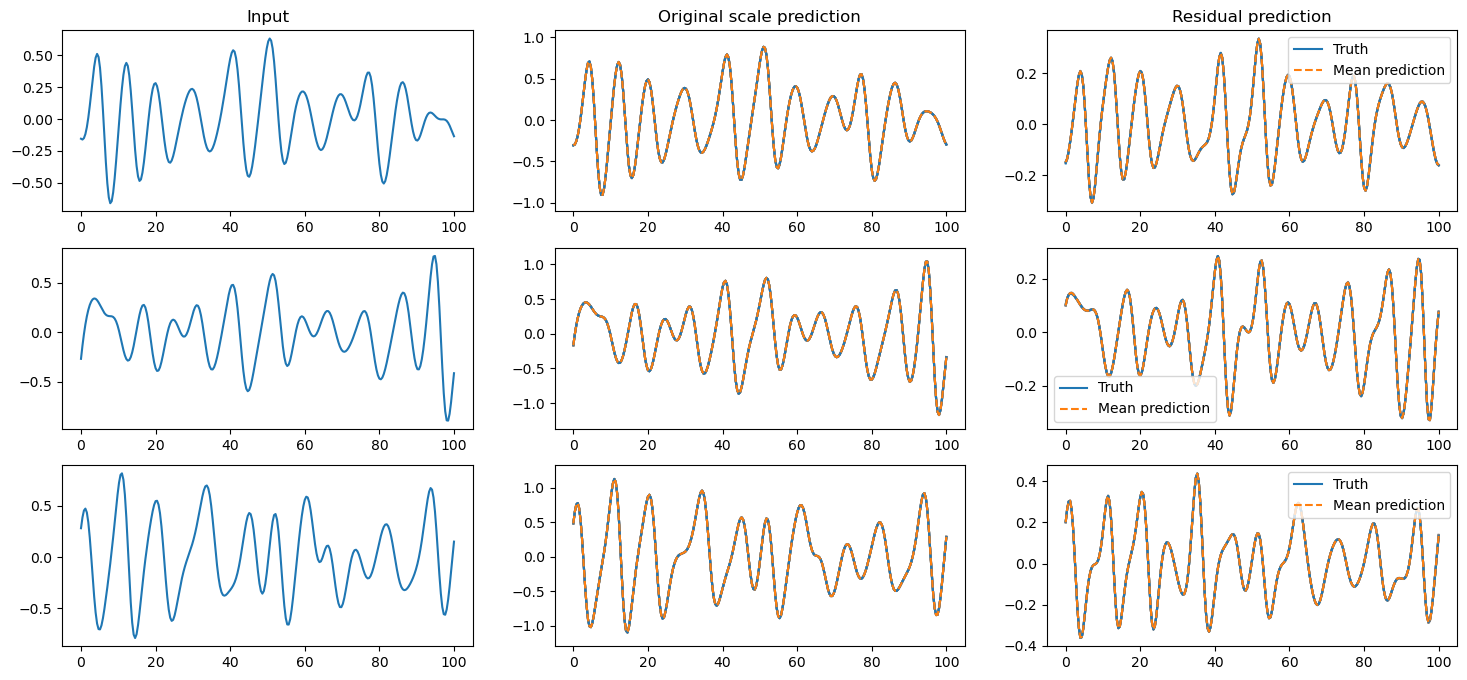

In [15]:
plot_predictions(input, target, pred, grid)

In [ ]:
def get_trajectory():
    grid_input = input[:,2:3,:]
    t0 = input[:,1:2,:]
    full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

    for i in range(n_samples):
        autoregressive_input = input.clone()
        pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
        for t in range(t_steps):
            pred = generate_diffusion_samples_low_dimensional(
                model=model,
                input = autoregressive_input,
                n_timesteps=n_timesteps,
                target_shape=target.shape,
                n_samples=1,
                distributional_method=distributional_method,
                x_T_sampling_method=x_T_sampling_method,
                cfg_scale=cfg_scale,
                noise_schedule="linear",
                beta_endpoints = beta_endpoints,
            )
            if t == 0:
                pred_array[...,t] = pred.squeeze(-1)+ t0
            else:
                pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

            if t == 1:
                autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
            elif t > 1:
                autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
        # Save
        full_array[...,i] = pred_array
        return full_array

In [16]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            beta_endpoints = beta_endpoints,
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

KeyboardInterrupt: 

TypeError: list indices must be integers or slices, not tuple

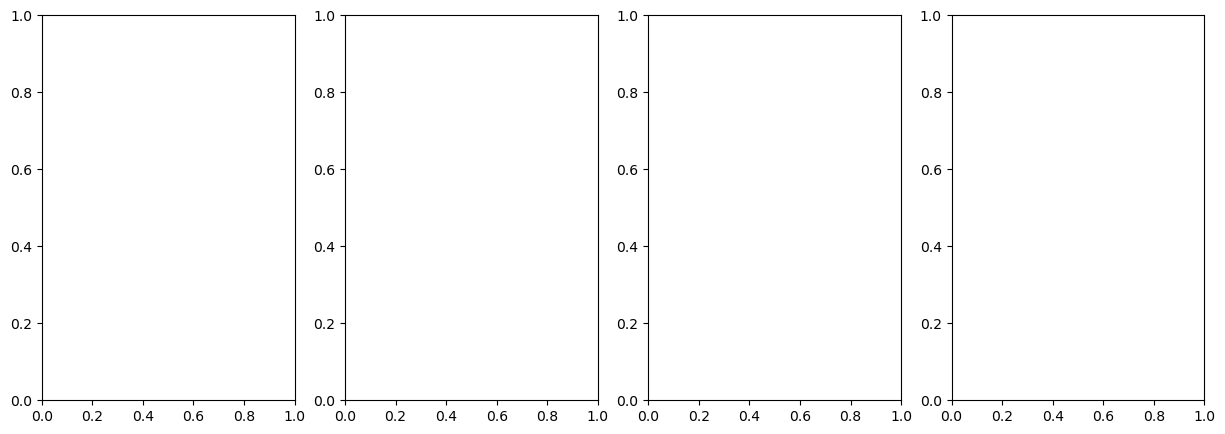

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Input")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Normal

In [ ]:
ckpt_path = "../results/KS/normal/Datetime_20250831_102648_Loss_1D_KS_UNet_diffusion_normal_T50_DDIM1.pt"
distributional_method = "normal"
beta_endpoints = (0.001, 0.2)

In [ ]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_normal(
    backbone=backbone,
    d=1,
    target_dim = 1,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_461374/467673265.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [ ]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints = beta_endpoints,
)

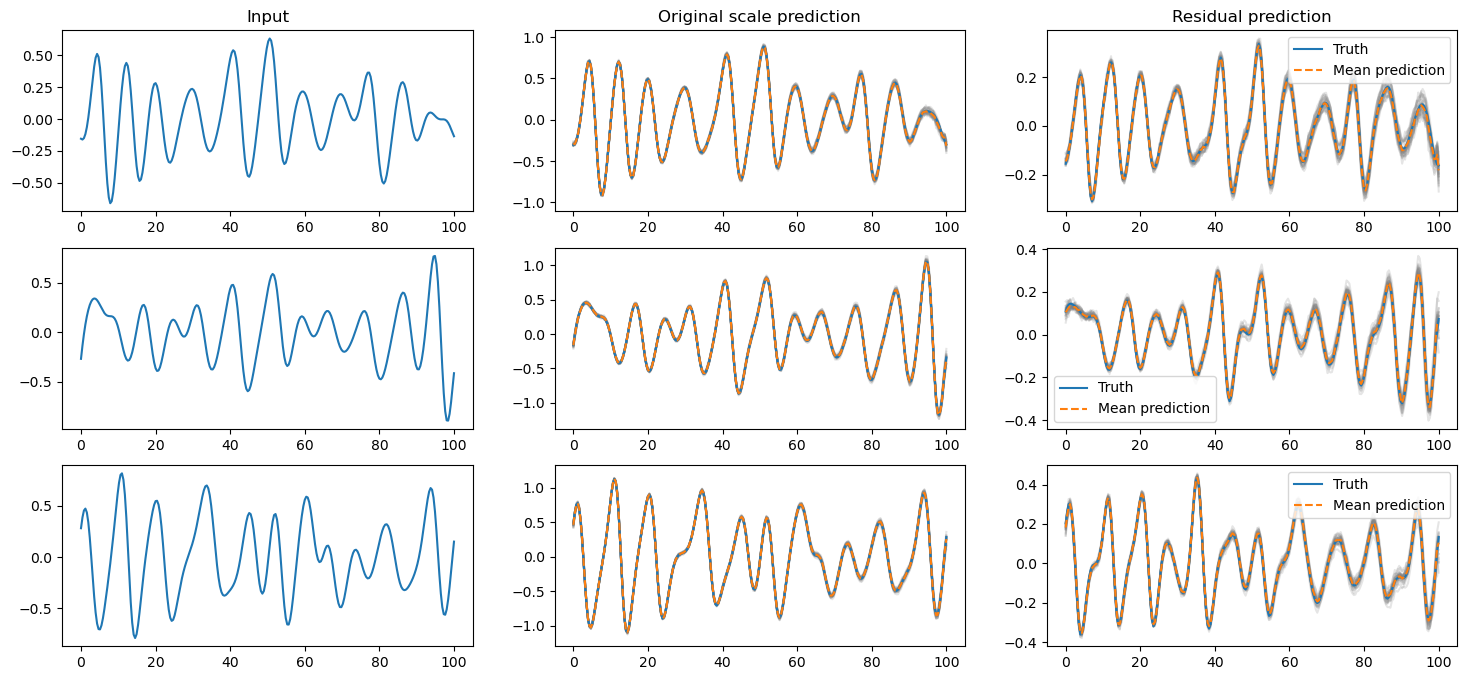

In [ ]:
plot_predictions(input, target, pred, grid)

In [ ]:
diffusion = DistributionalDiffusion(
    img_size=target.shape[1:], device=device, distributional_method=distributional_method, x_T_sampling_method=x_T_sampling_method
)
x = diffusion.sample_x_T((target.shape[0], *target_dim), pred)
t = (torch.ones(target.shape[0]) * 1000).long().to(device)
predicted_noise = model(x, t, input, pred = pred)

In [ ]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            beta_endpoints = beta_endpoints,
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

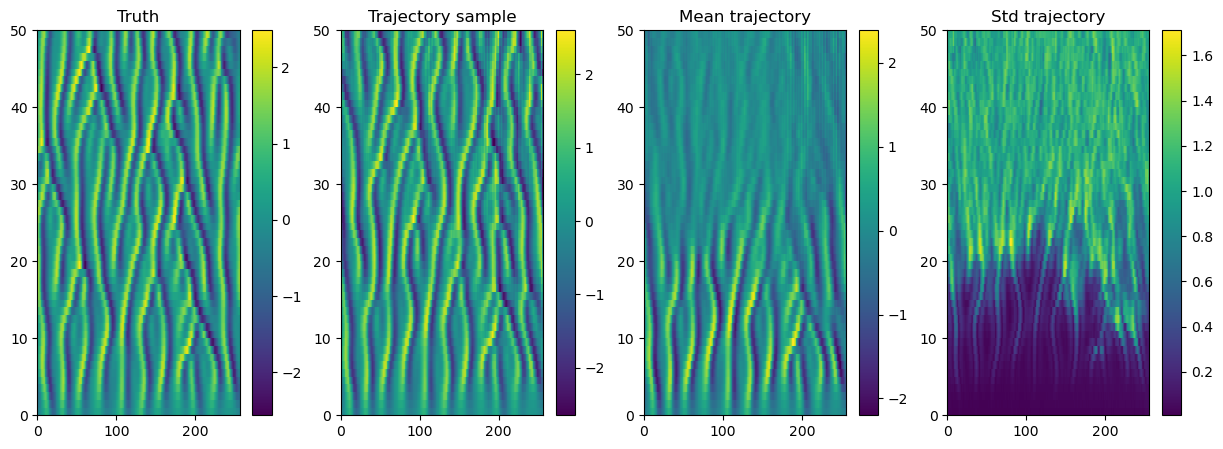

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Mixed normal

In [ ]:
ckpt_path = "../results/KS/mixednormal/Datetime_20250831_190236_Loss_1D_KS_UNet_diffusion_mixednormal_T50_DDIM1.pt"
distributional_method = "mixednormal"
beta_endpoints = (0.001, 0.2)

In [ ]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

model = UNet_diffusion_mixednormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    n_components=50,
)
model.load_state_dict(
    torch.load(ckpt_path, map_location=device)
)
model = model.to(device)


/tmp/ipykernel_461374/428214210.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(ckpt_path, map_location=device)


In [ ]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints = beta_endpoints,
)

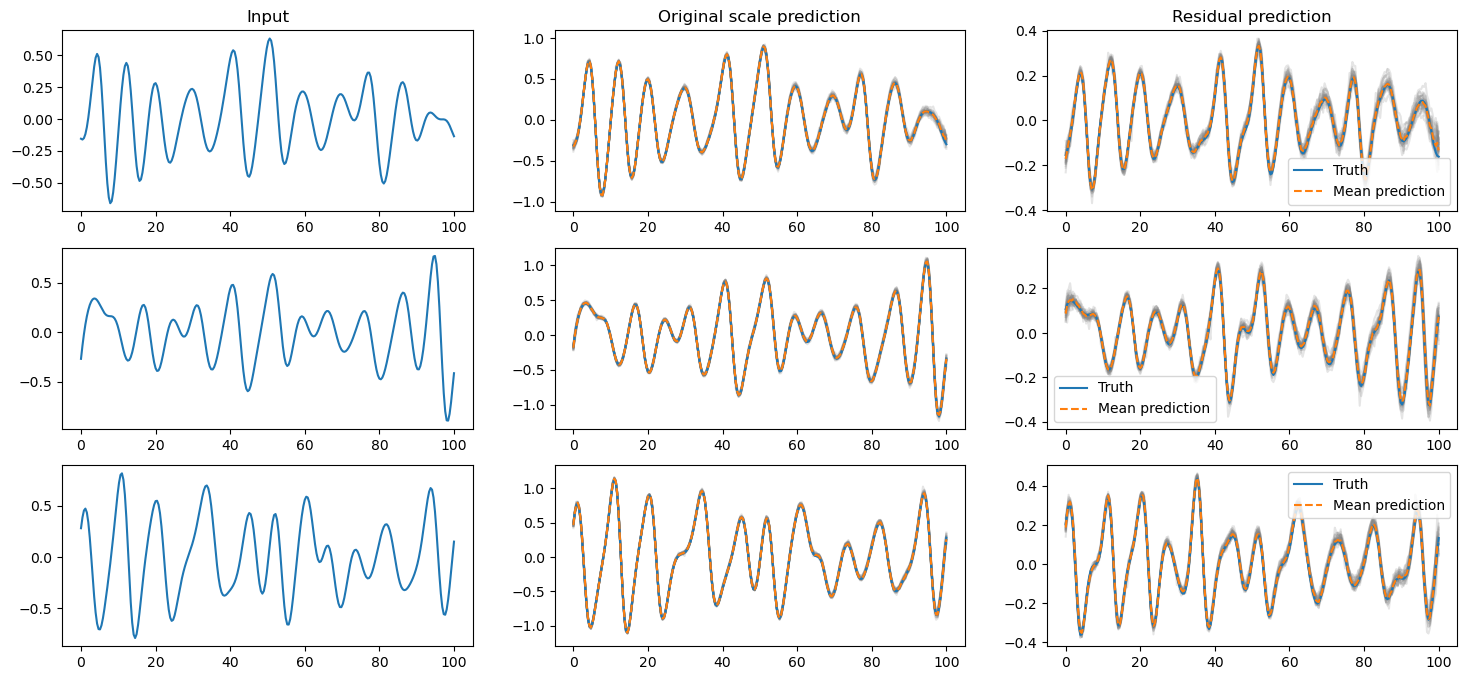

In [ ]:
plot_predictions(input, target, pred, grid)

In [ ]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            beta_endpoints = beta_endpoints,
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

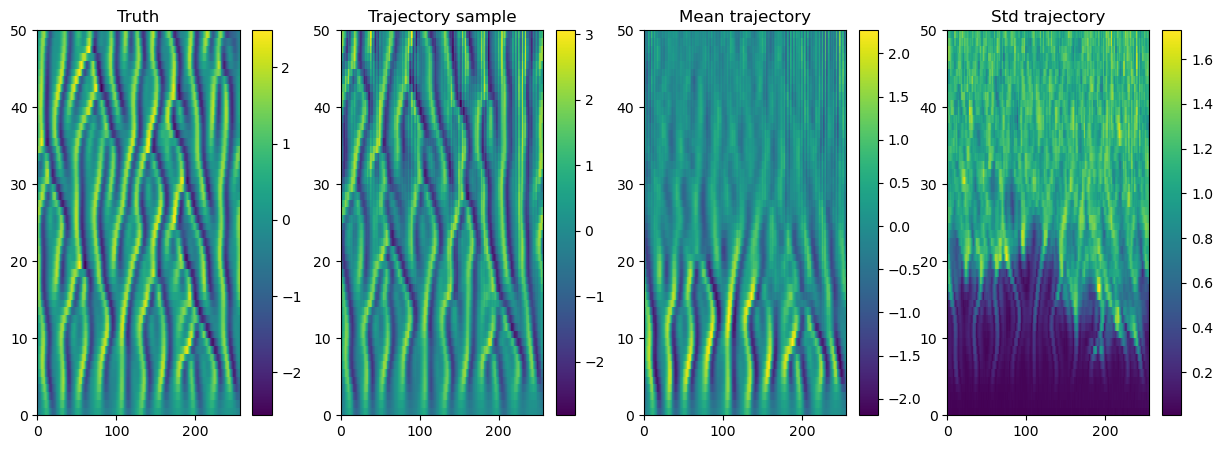

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Sample

In [ ]:
ckpt_path = "../results/KS/sample/Datetime_20250901_121308_Loss_1D_KS_UNet_diffusion_sample_T50_DDIM1.pt"
distributional_method = "sample"
beta_endpoints = (0.001, 0.35)

In [ ]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=4,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim[-1]
        )


model = UNet_diffusion_sample(
    backbone=backbone,
    d=1,
    target_dim = 1,
    hidden_dim=64
)



dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_385645/2306179049.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [ ]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=50,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints = beta_endpoints,
)

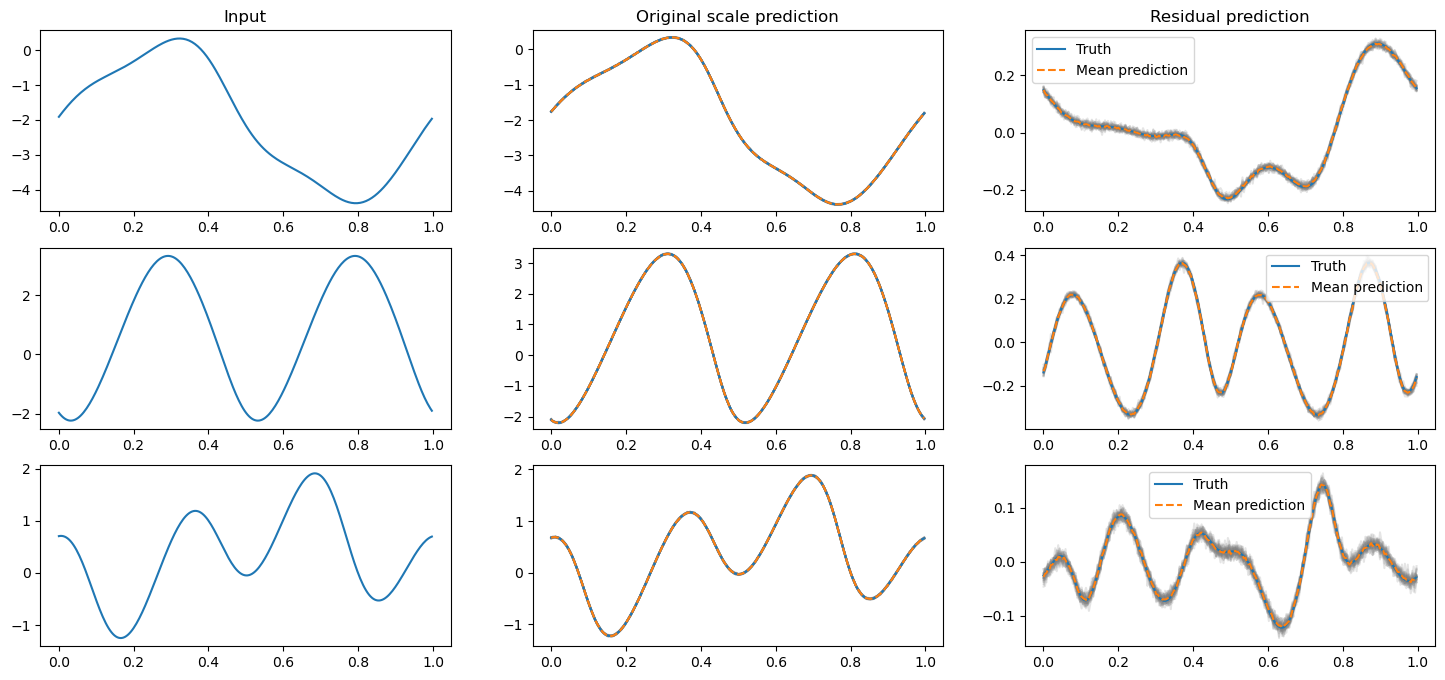

In [ ]:
plot_predictions(input, target, pred, grid)

In [ ]:

grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            beta_endpoints = beta_endpoints,
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

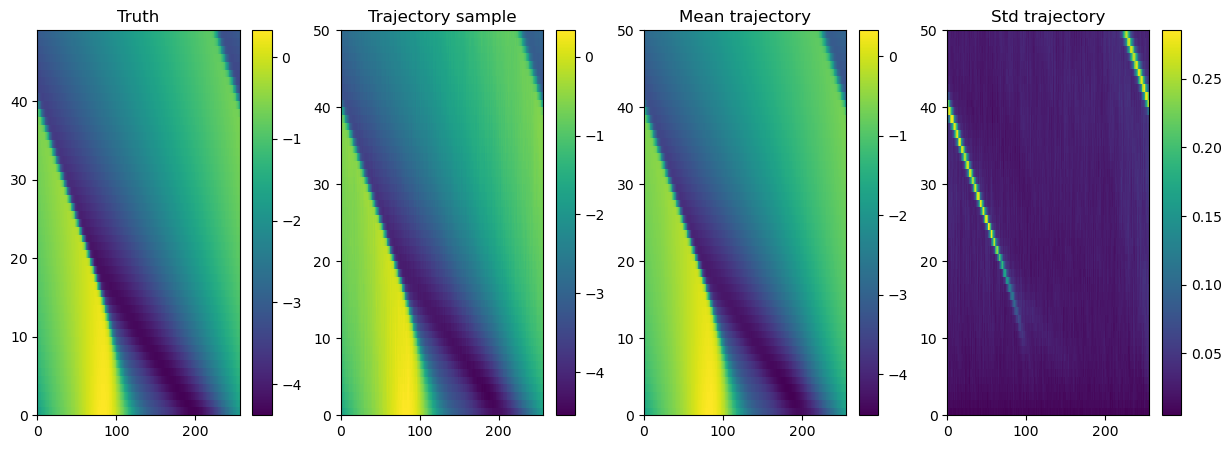

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

# Multivariate normal

In [ ]:
ckpt_path = "../results/KS/mvnormal/Datetime_20250901_062553_Loss_1D_KS_UNet_diffusion_mvnormal_T50_DDIM1.pt"
distributional_method = "mvnormal"
beta_endpoints = (0.001, 0.35)

In [ ]:
backbone =  UNetDiffusion(
            d=1,
            conditioning_dim=3,
            hidden_channels=64,
            in_channels=1,
            out_channels=1,
            init_features=64,
            domain_dim = target_dim
        )

#backbone.conditioning_projection = torch.nn.Identity()

model = UNet_diffusion_mvnormal(
    backbone=backbone,
    d=1,
    target_dim = 1,
    domain_dim = target_dim[1:],
    rank = 1,
    method = "lora"
)

dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(dict
    
)
model = model.to(device)


/tmp/ipykernel_461374/2695612951.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(ckpt_path, map_location=device)


In [ ]:
pred = generate_diffusion_samples_low_dimensional(
    model=model,
    input = input,
    n_timesteps=n_timesteps,
    target_shape=target.shape,
    n_samples=n_samples,
    distributional_method=distributional_method,
    x_T_sampling_method=x_T_sampling_method,
    cfg_scale=cfg_scale,
    noise_schedule="linear",
    beta_endpoints = beta_endpoints,
)

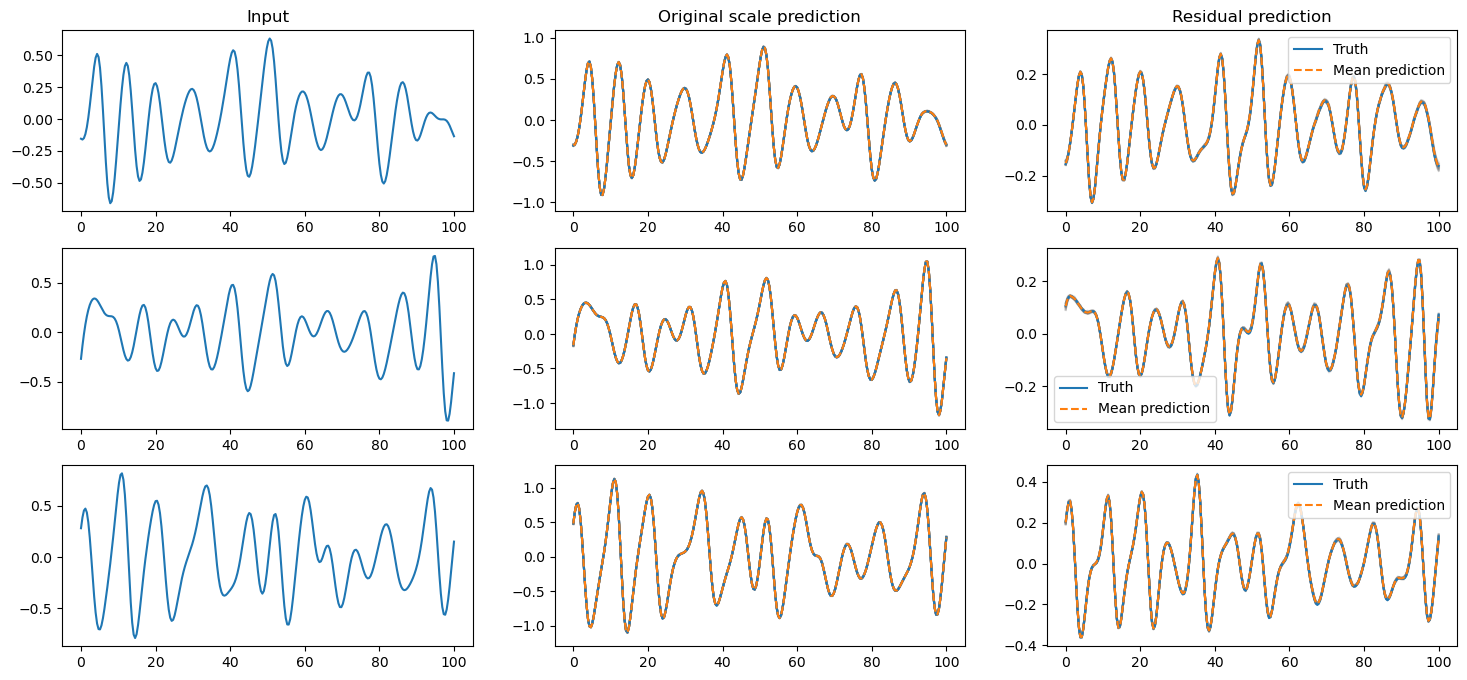

In [ ]:
plot_predictions(input, target, pred, grid)

In [ ]:
grid_input = input[:,2:3,:]
t0 = input[:,1:2,:]
full_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps,n_samples, device=device)

for i in range(n_samples):
    autoregressive_input = input.clone()
    pred_array = torch.zeros(input.shape[0], 1, input.shape[2], t_steps, device=device)
    for t in range(t_steps):
        pred = generate_diffusion_samples_low_dimensional(
            model=model,
            input = autoregressive_input,
            n_timesteps=n_timesteps,
            target_shape=target.shape,
            n_samples=1,
            distributional_method=distributional_method,
            x_T_sampling_method=x_T_sampling_method,
            cfg_scale=cfg_scale,
            noise_schedule="linear",
            beta_endpoints = beta_endpoints,
        )
        if t == 0:
            pred_array[...,t] = pred.squeeze(-1)+ t0
        else:
            pred_array[...,t] = pred.squeeze(-1) + pred_array[...,t-1]

        if t == 1:
            autoregressive_input = torch.cat([t0, pred_array[...,0], grid_input], dim = 1)
        elif t > 1:
            autoregressive_input = torch.cat([pred_array[...,t-1],pred_array[...,t], grid_input], dim = 1)
    # Save
    full_array[...,i] = pred_array

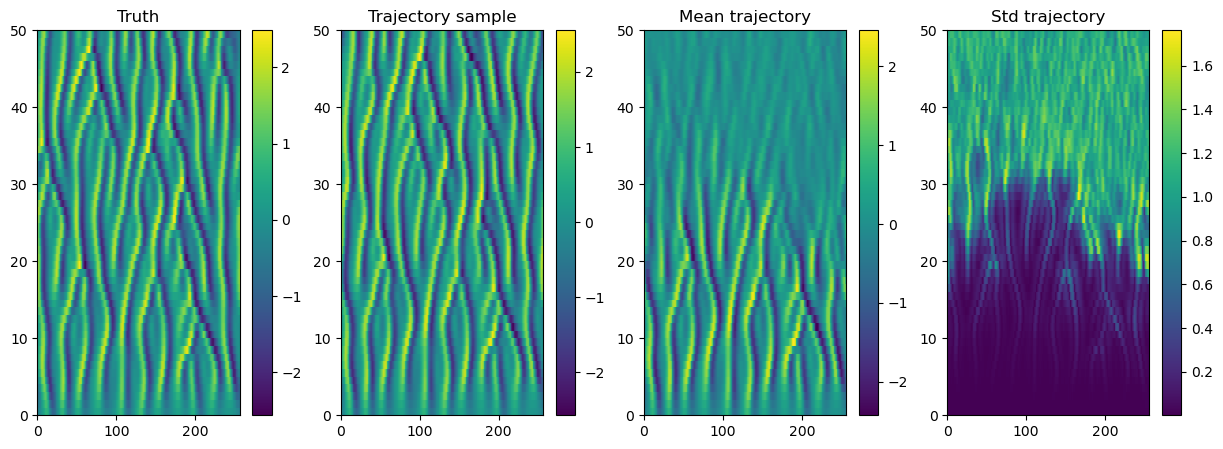

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (15,5))

im1 = axs[0].pcolormesh(trajectory[b,0,2:].cpu())
axs[0].set_title("Truth")
cb1 = fig.colorbar(im1, ax = axs[0])

im2 = axs[1].pcolormesh(full_array[b,0,...,0].t().cpu())
axs[1].set_title("Trajectory sample")
cb1 = fig.colorbar(im2, ax = axs[1])

im3 = axs[2].pcolormesh(full_array[b,0].mean(axis = -1).t().cpu())
axs[2].set_title("Mean trajectory")
cb1 = fig.colorbar(im3, ax = axs[2])

im4 = axs[3].pcolormesh(full_array[b,0].std(axis = -1).t().cpu())
axs[3].set_title("Std trajectory")
cb1 = fig.colorbar(im4, ax = axs[3])

: 

: 

: 

: 